In [1]:
! jt -t grade3 -nf opensans

<h1><center>1. Load Data</center></h1>



In [2]:
import os
import warnings
import pandas as pd

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os

In [4]:
os.environ['EVALUATION'] = 'demo'
os.environ['METRICS_PATH'] = '/Users/denis/IdeaProjects/synthesized/evaluation/metrics.jsonl'
os.environ['CONFIG'] = """{
    "data_path": "/Users/denis/IdeaProjects/synthesized/data/credit_with_categoricals.csv",
    "params": { "exclude_encoding_loss": true },
    "num_iterations": 5000
}"""
os.environ['REVISION'] = 'n/a'
os.environ['BRANCH'] = 'n/a'

In [5]:
from synthesized.testing.evaluation import Evaluation
evaluation = Evaluation()

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3138-2D31-322D-B531
Expires at: 2018-12-31 00:00:00


In [15]:
data = pd.read_csv(evaluation.config['data_path'])
data.dropna(inplace=True)
data.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,effort,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,"(0.00649, 0.04]",9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,"(0.000309, 0.00134]",2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,"(0.000309, 0.00134]",3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,"(0.000309, 0.00134]",3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,"(-0.001, 0.000309]",63588.0,7,0,1,0,0.0
5,0,0.213179,74,0,"(0.00367, 0.00468]",3500.0,3,0,1,0,1.0
7,0,0.754464,39,0,"(0.00134, 0.00214]",3500.0,8,0,0,0,0.0
9,0,0.189169,57,0,"(0.00468, 0.00649]",23684.0,9,0,4,0,2.0
10,0,0.644226,30,0,"(0.00287, 0.00367]",2500.0,5,0,0,0,0.0
11,0,0.018798,51,0,"(0.00468, 0.00649]",6501.0,7,0,2,0,2.0






<h1><center>2. Train model and generate synthetic data</center></h1>

In [16]:
from sklearn.model_selection import train_test_split
from synthesized.core import BasicSynthesizer

In [17]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [18]:
def synthesize():
    return data.sample(10000)
    #with BasicSynthesizer(data=data, **evaluation.config['params']) as synthesizer:
        #synthesizer.learn(data=train, num_iterations=evaluation.config['num_iterations'])
        #return synthesizer.synthesize(n=len(test))

In [19]:
synthesized = [synthesize() for i in range(3)]

## Display aggregated statistics 

In [20]:
from scipy.stats import ks_2samp
import numpy as np
import seaborn as sns

In [21]:
synthesizer = BasicSynthesizer(data=data)

value types:
SeriousDlqin2yrs categorical2-22
RevolvingUtilizationOfUnsecuredLines continuous-nonnegative
age categorical83-141-similarity
NumberOfTime30-59DaysPastDueNotWorse categorical16-88-similarity
effort categorical10-73
MonthlyIncome continuous-nonnegative
NumberOfOpenCreditLinesAndLoans categorical58-129-similarity
NumberOfTimes90DaysLate categorical19-94-similarity
NumberRealEstateLoansOrLines categorical28-106-similarity
NumberOfTime60-89DaysPastDueNotWorse categorical13-82-similarity
NumberOfDependents categorical13-82-similarity


In [24]:
def plot_avg_distances():
    test_ = synthesizer.preprocess(test.copy())
    result = []
    for i, s in enumerate(synthesized):
        synthesized_ = synthesizer.preprocess(s.copy())
        distances = [ks_2samp(test_[col], synthesized_[col])[0] for col in synthesized_.columns]
        avg_distance = np.mean(distances)
        print('run: {}, AVG distance: {}'.format(i+1, avg_distance))
        result.append({'run': i+1, 'avg_distance': avg_distance})
        evaluation['avg_distance'] = avg_distance
    df = pd.DataFrame.from_records(result)
    df['run'] = df['run'].astype('category')
    g = sns.barplot(y='run', x='avg_distance', data=df)
    g.set_xlim(0.0, 1.0)

run: 1, AVG distance: 0.007827675608668382
run: 2, AVG distance: 0.005853654277874795
run: 3, AVG distance: 0.0079135762715708


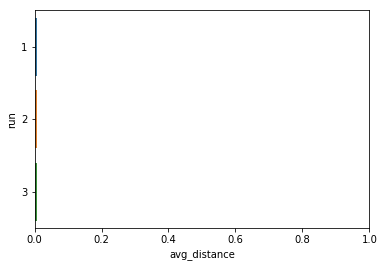

In [25]:
plot_avg_distances()

## Details for the 1st Run 

In [26]:
from synthesized.testing import UtilityTesting
testing = UtilityTesting(synthesizer, train, test, synthesized[0])

Average distance: 0.007827675608668382


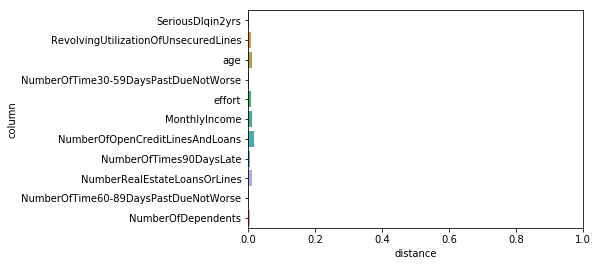

In [27]:
testing.show_distribution_distances()

/Users/denis/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


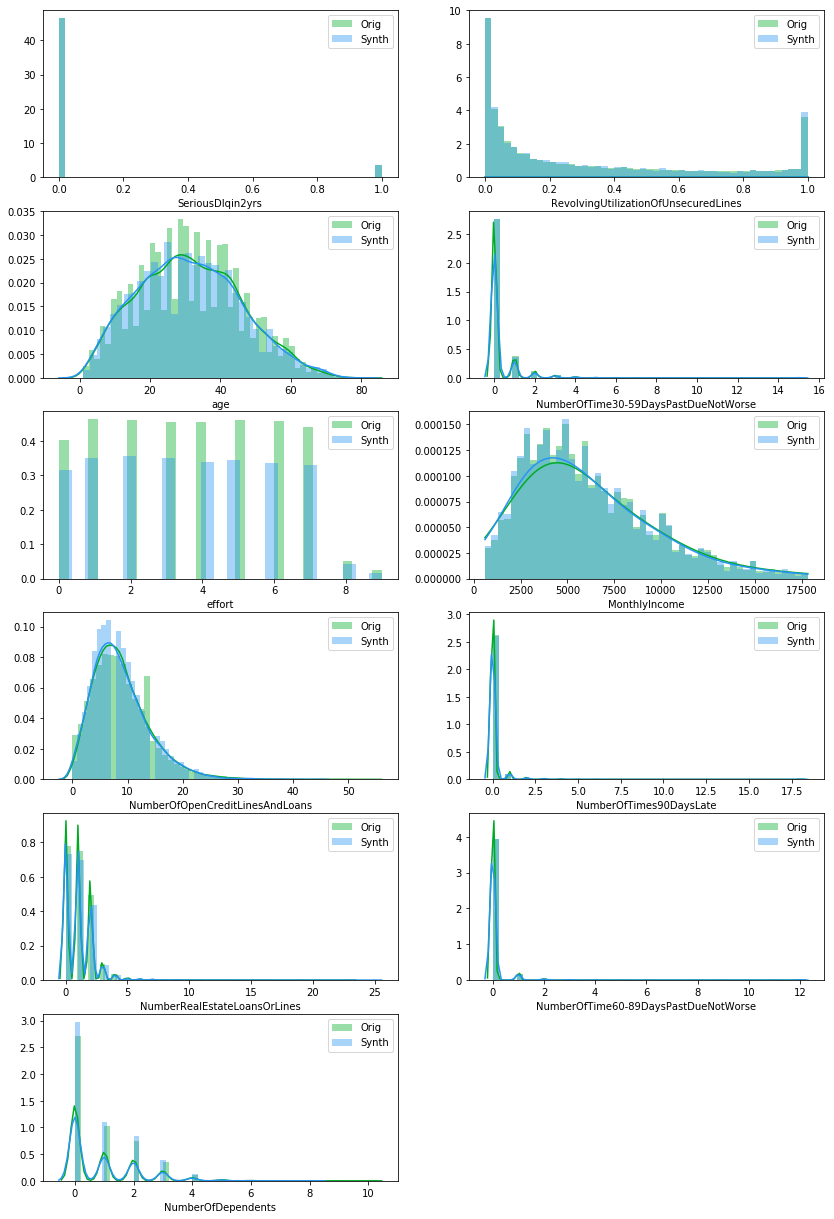

In [28]:
testing.show_distributions()

## Display correlations

Average diff: 0.0058455928888645125


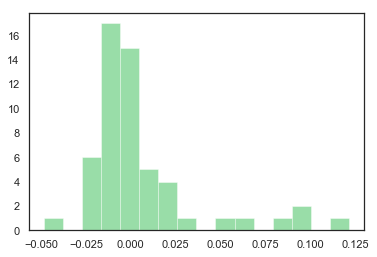

In [31]:
testing.show_correlation_diffs(threshold=0.2)

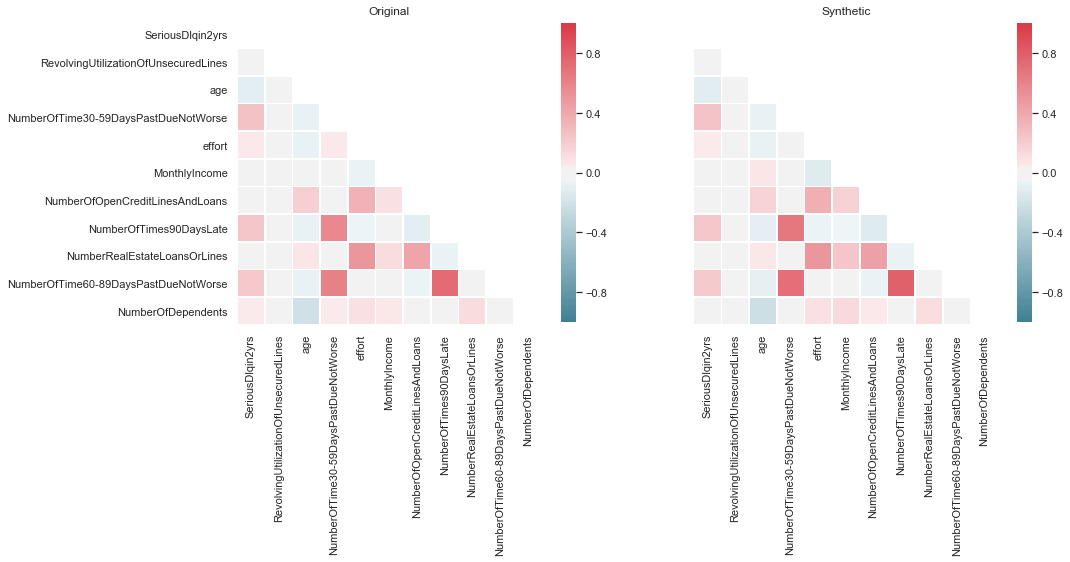

In [32]:
testing.show_corr_matrices()

## Demonstrate the utility for training ML models

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
evaluation['utility'] = testing.utility(target='SeriousDlqin2yrs', classifier=GradientBoostingClassifier())

ROC AUC (orig): 0.8576034437147926
ROC AUC (synth): 0.853938771662796


In [35]:
evaluation.write_metrics()